In [107]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from data_analysis.utils import user
from data.paths.parquet_paths import USER, REVIEW

In [108]:
user_df = pd.read_parquet(str(USER))
review_df = pd.read_parquet(str(REVIEW))

In [109]:
user_df = user.prepare_user_df(user_df)

In [110]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             10000 non-null  object        
 1   name                10000 non-null  object        
 2   review_count        10000 non-null  int32         
 3   yelping_since       10000 non-null  datetime64[ns]
 4   friends             10000 non-null  object        
 5   useful              10000 non-null  int32         
 6   funny               10000 non-null  int32         
 7   cool                10000 non-null  int32         
 8   fans                10000 non-null  int32         
 9   elite               0 non-null      object        
 10  average_stars       10000 non-null  float32       
 11  compliment_hot      10000 non-null  int32         
 12  compliment_more     10000 non-null  int32         
 13  compliment_profile  10000 non-null  int32      

In [111]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float32
 4   date         100000 non-null  object 
 5   text         100000 non-null  object 
 6   useful       100000 non-null  int32  
 7   funny        100000 non-null  int32  
 8   cool         100000 non-null  int32  
dtypes: float32(1), int32(3), object(5)
memory usage: 5.3+ MB


In [112]:
# user_df['user_id'] = user_df['user_id'].astype(str)
# review_df['user_id'] = review_df['user_id'].astype(str)

user_columns = [
    'user_id',
    'name',
    'review_count',
    'yelping_since',
    # 'useful',
    # 'funny',
    # 'cool',
    'fans',
    'average_stars'
]


review_user_df = review_df.join(user_df[user_columns].set_index('user_id'), on='user_id')
review_user_df['date'] = pd.to_datetime(review_user_df['date'])

In [113]:
review_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   review_id      100000 non-null  object        
 1   user_id        100000 non-null  object        
 2   business_id    100000 non-null  object        
 3   stars          100000 non-null  float32       
 4   date           100000 non-null  datetime64[ns]
 5   text           100000 non-null  object        
 6   useful         100000 non-null  int32         
 7   funny          100000 non-null  int32         
 8   cool           100000 non-null  int32         
 9   name           8279 non-null    object        
 10  review_count   8279 non-null    float64       
 11  yelping_since  8279 non-null    datetime64[ns]
 12  fans           8279 non-null    float64       
 13  average_stars  8279 non-null    float32       
dtypes: datetime64[ns](2), float32(2), float64(2), int32(3

In [114]:
review_user_df = review_user_df.loc[~review_user_df['name'].isna()].copy()

In [115]:
review_user_df.sample(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars
2198,LeTqlL9-6OeYtxrbF1QE1Q,SvkOt67Q4pOw2oviK_13og,_V0yJdpXrbdKzBDoVSJGWA,2.0,2014-04-03,"For the most part, you'll find me in casinos o...",3,0,0,Hugo,41.0,2009-05-05 11:06:51,5.0,4.20
35059,fHJ0qWpB96q76-o2ZJKxOw,E0hnzH2Kx50pYjIOhMxfuA,qFAw6wHMMcr4ctF-ZdGhEA,4.0,2015-07-18,4.5 Stars\n\nI know that the garlic knots are ...,2,1,1,Eddie,1339.0,2009-03-16 07:27:26,109.0,3.53


<AxesSubplot: >

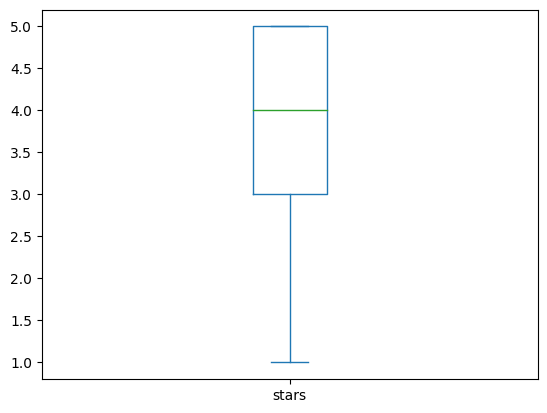

In [116]:
review_user_df.groupby('user_id')['stars'].mean().plot(kind='box')

In [117]:
# early reviews: within month or two after yelping since
youth_threshold = timedelta(days=60)
early_reviews = review_user_df[review_user_df.date - review_user_df.yelping_since < youth_threshold]

early_reviews[['date', 'yelping_since', 'stars', 'user_id']].sample(10)

early_reviews = early_reviews.groupby('user_id').agg(list)
early_reviews.reset_index(inplace=True)
early_reviews['count'] = early_reviews['name'].apply(lambda x: len(x))
early_reviews[early_reviews['count'] >= 3].sample(3)

,user_id,review_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
505,rZQCd47n7OwPd71igVX6Og,"[6s3FEmaS0AQGjh6WqCCoTQ, zfzMjbAKy__5Ae6NrSuyV...","[KEaCHdsY7w7CBsZ6h2dLeQ, ysJo5Jdo29XOBCnKrbUKW...","[5.0, 5.0, 4.0]","[2011-03-24 00:00:00, 2011-03-21 00:00:00, 201...","[The perfect, no frills, waking distance Thai ...","[0, 0, 2]","[0, 0, 0]","[0, 0, 0]","[Melissa, Melissa, Melissa]","[111.0, 111.0, 111.0]","[2011-03-16 02:14:36, 2011-03-16 02:14:36, 201...","[9.0, 9.0, 9.0]","[3.5799999237060547, 3.5799999237060547, 3.579...",3
539,wXi-P691AGOdonMy1TrL7w,"[q2-hSGg2uaNJUvxpAFtM1g, iVB37kLR8EpYAS7SV1MAh...","[OeHlIu7ybVZLoclcweHImw, PlcZM0TyPw8JSRQqGjTdB...","[2.0, 4.0, 3.0, 4.0]","[2009-10-14 00:00:00, 2009-10-24 00:00:00, 200...","[So, once upon a time I fancied myself a rocke...","[5, 0, 6, 0]","[4, 2, 0, 0]","[1, 2, 0, 1]","[Katie, Katie, Katie, Katie]","[367.0, 367.0, 367.0, 367.0]","[2009-09-25 23:13:32, 2009-09-25 23:13:32, 200...","[34.0, 34.0, 34.0, 34.0]","[3.690000057220459, 3.690000057220459, 3.69000...",4
10,-pXs08gJq9ExIk275YLvPg,"[GiMzuG-2toWBxoDoWPkqdg, 46aMTtGregrW8f4zky9PX...","[uLyeGUKKi_hDlnhEEqsDPA, z5dE6ACPVnoyOOiAynMhm...","[3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 3.0, ...","[2008-12-03 00:00:00, 2008-12-12 00:00:00, 200...",[this spot has an ample supply of different pr...,"[0, 0, 0, 2, 0, 1, 1, 1, 0, 3, 1]","[0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[Jimi, Jimi, Jimi, Jimi, Jimi, Jimi, Jimi, Jim...","[392.0, 392.0, 392.0, 392.0, 392.0, 392.0, 392...","[2008-10-30 22:55:06, 2008-10-30 22:55:06, 200...","[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....","[3.8399999141693115, 3.8399999141693115, 3.839...",11


In [118]:
review_bursts = review_user_df.groupby(['user_id', 'date']).agg(list)
review_bursts.reset_index(inplace=True)
review_bursts['count'] = review_bursts['name'].apply(lambda x: len(x))
review_bursts[review_bursts['count'] >= 3].sample(3)

,user_id,date,review_id,business_id,stars,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
449,33v8c5ftrKuDGTw1ZQ2toQ,2013-02-23,"[6yvrBKmulTlYv0pQz37i3Q, E8e-51zOgmtFzY13lAArr...","[AdtaU4YPa5ejSsepQHfkQA, 6Pk9PJOD7EWd1tv3lk0aj...","[2.0, 3.0, 3.0]",[Kind of a dingy version of the Walgreen's cha...,"[0, 0, 0]","[0, 0, 2]","[0, 0, 0]","[Tom, Tom, Tom]","[569.0, 569.0, 569.0]","[2009-06-06 18:49:47, 2009-06-06 18:49:47, 200...","[34.0, 34.0, 34.0]","[3.7899999618530273, 3.7899999618530273, 3.789...",3
795,5snWEoA7Qsu-H7nY4aTpAQ,2015-02-24,"[9Oon-b4NXhSK0Jm2qz-ieQ, 9lw37_PAyjYaSgobO6dZ-...","[1G9RIh0r2QgCDPwVzzkTgw, L76ie7o_M1F4GFVBnDfWS...","[3.0, 2.0, 3.0]",[Winners is only good during their clearance s...,"[1, 2, 1]","[1, 1, 1]","[1, 1, 1]","[Mila, Mila, Mila]","[138.0, 138.0, 138.0]","[2010-03-15 21:20:04, 2010-03-15 21:20:04, 201...","[5.0, 5.0, 5.0]","[3.5199999809265137, 3.5199999809265137, 3.519...",3
7533,xkmwzqyy4ZSMsEIejwq41w,2013-09-06,"[Fx34YwTqTcjB_bbC19aoIg, _Ut9sCW6-_GmIVG4VlmCm...","[Rb2s2-2kIvbPXnPEuM_OBg, LpJvitnw7vU5UW-3KE9kj...","[3.0, 5.0, 3.0]","[Nice staff, the food took a little long to co...","[0, 3, 1]","[0, 0, 0]","[1, 3, 1]","[Faye, Faye, Faye]","[753.0, 753.0, 753.0]","[2010-04-11 01:14:30, 2010-04-11 01:14:30, 201...","[56.0, 56.0, 56.0]","[3.9700000286102295, 3.9700000286102295, 3.970...",3
100,-pXs08gJq9ExIk275YLvPg,2008-12-09,"[oYy5PYC8seNfkJkVWxG7Iw, yCaEi3qWZcy22JxB6GaHH...","[6z8niWBqVsjyenVG5_LtDw, DftK-qzebIR829HozNYfg...","[4.0, 4.0, 4.0, 4.0]",[the opera house is a really fun venue and con...,"[0, 1, 3, 1]","[0, 0, 0, 2]","[0, 0, 0, 1]","[Jimi, Jimi, Jimi, Jimi]","[392.0, 392.0, 392.0, 392.0]","[2008-10-30 22:55:06, 2008-10-30 22:55:06, 200...","[18.0, 18.0, 18.0, 18.0]","[3.8399999141693115, 3.8399999141693115, 3.839...",4


In [119]:
# ~14 years * ~50 weeks
bins_count = 700
review_user_df['date_bin'] = pd.cut(review_user_df['date'], bins=bins_count, labels=range(bins_count))

review_bursts_binned = review_user_df.groupby(['user_id', 'date_bin']).agg(list)
review_bursts_binned.reset_index(inplace=True)
review_bursts_binned = review_bursts_binned.dropna()
review_bursts_binned['count'] = review_bursts_binned['name'].apply(lambda x: len(x))
review_bursts_binned[review_bursts_binned['count'] >= 3].sample(3)

,user_id,date_bin,review_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
3120850,wXi-P691AGOdonMy1TrL7w,250,"[-YIicJCTaAwN4SnvMQICrw, 01iRuws83ozzlrUH-sUdH...","[FYBvbA08gi71dLc-RxqxKQ, eo3kAvg_1622OmbxjWKEg...","[4.0, 3.0, 4.0, 4.0]","[2010-01-10 00:00:00, 2010-01-10 00:00:00, 201...",[I live really close to Edmonton Trail and oft...,"[8, 1, 7, 1]","[1, 0, 0, 0]","[2, 0, 0, 1]","[Katie, Katie, Katie, Katie]","[367.0, 367.0, 367.0, 367.0]","[2009-09-25 23:13:32, 2009-09-25 23:13:32, 200...","[34.0, 34.0, 34.0, 34.0]","[3.690000057220459, 3.690000057220459, 3.69000...",4
201360,3AV5ONopdwL5qKYW20SRdg,460,"[PmocRdCBKCY63VBmT7LeeQ, eHTYloJpHUJH7HtbR4Wpv...","[Xs2iTWxbczvfEapAFH3cyw, C0C7IxBSC1df0FwXODZCv...","[4.0, 5.0, 5.0]","[2014-02-09 00:00:00, 2014-02-09 00:00:00, 201...",[Great food! Nice portions. Featured on the FO...,"[1, 0, 0]","[0, 0, 1]","[0, 0, 0]","[Jenifer, Jenifer, Jenifer]","[340.0, 340.0, 340.0]","[2009-06-23 03:59:59, 2009-06-23 03:59:59, 200...","[41.0, 41.0, 41.0]","[3.890000104904175, 3.890000104904175, 3.89000...",3
1103603,KQm9OgdujLZiMRTksmj83w,403,"[xtchdlkc7mwdQKJLxcIBIQ, 05JFwgXa73hfNXVgTsMWD...","[uAjdyhWYTu1Vhvs-nW0bGQ, _cs_J4j8XXyBgihJs83qU...","[5.0, 1.0, 2.0]","[2013-01-03 00:00:00, 2013-01-02 00:00:00, 201...",[I only went here to get a prescription filled...,"[0, 2, 2]","[1, 1, 2]","[0, 0, 1]","[Melanie, Melanie, Melanie]","[328.0, 328.0, 328.0]","[2009-11-08 00:40:44, 2009-11-08 00:40:44, 200...","[40.0, 40.0, 40.0]","[3.880000114440918, 3.880000114440918, 3.88000...",3


In [120]:
early_reviewers = set(early_reviews['user_id'])
oneday_burst_reviewers = set(review_bursts['user_id'])
oneweek_burst_reviewers = set(review_bursts_binned['user_id'])

print(f'1d / 1w: {len(oneday_burst_reviewers.intersection(oneweek_burst_reviewers))}')
print(f'early / 1w: {len(early_reviewers.intersection(oneweek_burst_reviewers))}')
print(f'early / 1d: {len(early_reviewers.intersection(oneday_burst_reviewers))}')

1d / 1w: 4692
early / 1w: 558
early / 1d: 558


In [121]:
from data.paths.parquet_paths import BUSINESS
from data_analysis.utils import business

business_df = pd.read_parquet(str(BUSINESS))
business_df = business.prepare_business_df(business_df)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, iBof5Tl8vrKISbi82tFEvQ to 9999
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        10000 non-null  object 
 1   address                     10000 non-null  object 
 2   city                        10000 non-null  object 
 3   state                       10000 non-null  object 
 4   postal_code                 10000 non-null  object 
 5   latitude                    10000 non-null  float32
 6   longitude                   10000 non-null  float32
 7   stars                       10000 non-null  float32
 8   review_count                10000 non-null  float64
 9   is_open                     10000 non-null  float64
 10  categories                  10000 non-null  object 
 11  hours                       7716 non-null   object 
 12  AcceptsInsurance            413 non-null    object 
 13  AgesAllowed     

In [122]:
# Searching for home state
# taking users activity
# grouping by user
# checking for the most visted / visited for longest time

review_place_df = review_user_df[['user_id', 'business_id', 'date']]
review_place_df = review_place_df.join(business_df[['city', 'state', 'latitude', 'longitude']], rsuffix='_business', on='business_id')
review_place_df = review_place_df.dropna()
review_place_df

,user_id,business_id,date,city,state,latitude,longitude
3,zEOuNc4K40aw-GE6y8RgIg,Y6FNieFd5UKhJ3a6FbQhyg,2014-07-28,Gilbert,AZ,33.378639,-111.755966
34,fJezNrc49UX9gONGNJ4YUQ,4gwh0q7JsdzHIm_pdYUlZg,2013-02-22,Scottsdale,AZ,33.539532,-111.924576
82,UYcmGbelzRa0Q6JqzLoguw,Er5XAY2UFGGqBHdqpeCFkA,2013-08-04,Las Vegas,NV,36.010628,-115.174904
87,whqfWVBj4x5EDboIVDOymQ,CsLQLiRoafpJPJSkNX2h5Q,2010-03-13,Charlotte,NC,35.194893,-80.767441
93,Y1ICO26IsN7i_1OVD0Inyw,GHs7grPeyVPwmiVKhhfMvg,2008-05-02,Glendale,AZ,33.534256,-112.261200
...,...,...,...,...,...,...,...
99827,Wmh9vK9LX-sxeuTb6vzM2A,36pB0QVVNZuOLV_UxosbAQ,2018-08-27,Montréal,QC,45.479313,-73.584496
99830,U13tLFucJNz1fNv_Xgdj0g,WCqcYtJ4rUxA4bIzjOfzqg,2013-05-11,Charlotte,NC,35.226147,-80.844231
99856,PYRIiQilTl1rkx83hm8ttA,LHXisknIbUy_XtdEQc7x9w,2014-05-13,Las Vegas,NV,36.060051,-115.164833
99892,SBsQvmEEYJsD6xeRzHxf8Q,aRqxT28Tdz2aDiZ7Vkyejw,2013-06-01,Toronto,ON,43.664177,-79.414963


In [123]:
state_mode = (review_place_df
    .groupby(['user_id'])['state']
    .agg(lambda x: pd.Series.mode(x)[0])
    .reset_index()
    .set_index('user_id'))
city_mode = (review_place_df
    .groupby(['user_id'])['city']
    .agg(lambda x: pd.Series.mode(x)[0])
    .reset_index()
    .set_index('user_id'))

user_home_byvisits = state_mode.join(city_mode, on='user_id')
user_home_byvisits.reset_index()

,user_id,state,city
0,---1lKK3aKOuomHnwAkAow,NV,Las Vegas
1,--RlSfc-QmcHFGHyX6aVjA,NV,Las Vegas
2,-1BrzE0pqO_EVw9SGzHEnw,NV,Las Vegas
3,-6J2VjbeLWAHsyAB8VN7bA,AZ,Glendale
4,-6iqrpnSPBW2plS8y7-cLA,NC,Charlotte
...,...,...,...
2750,zwmw_cNa5DzJotaFOHTvQg,AZ,Scottsdale
2751,zx6gq8IslnAwCyCUztXn1A,AZ,Scottsdale
2752,zy2ImADN9B0cvIRCC3d0Zg,AZ,Gilbert
2753,zyNGr5Tlg1rK1frevXCx2g,AZ,Scottsdale


In [124]:
# How to check by time?
# for each pair of reviews from same state/city count deltas between visits, max delta is homestate, homecity
from itertools import combinations

state_delta = review_place_df.groupby(['user_id', 'state']).apply(lambda x:
    sum(map(lambda dates: abs((dates[1] - dates[0]).days), combinations(x['date'], 2))))
    
state_mode_time = (state_delta.groupby(['user_id', 'state'])
    .max()
    .reset_index()[['user_id', 'state']]
    .drop_duplicates(['user_id'])
    .set_index('user_id'))

city_delta = review_place_df.groupby(['user_id', 'city']).apply(lambda x:
    sum(map(lambda dates: abs((dates[1] - dates[0]).days), combinations(x['date'], 2))))
city_mode_time = (city_delta.groupby(['user_id', 'city'])
    .max()
    .reset_index()[['user_id', 'city']]
    .drop_duplicates(['user_id'])
    .set_index('user_id'))

user_home_bydelta = state_mode_time.join(city_mode_time, on='user_id')
user_home_bydelta.reset_index()

,user_id,state,city
0,---1lKK3aKOuomHnwAkAow,NV,Las Vegas
1,--RlSfc-QmcHFGHyX6aVjA,NV,Las Vegas
2,-1BrzE0pqO_EVw9SGzHEnw,NV,Las Vegas
3,-6J2VjbeLWAHsyAB8VN7bA,AZ,Glendale
4,-6iqrpnSPBW2plS8y7-cLA,NC,Charlotte
...,...,...,...
2750,zwmw_cNa5DzJotaFOHTvQg,AZ,Scottsdale
2751,zx6gq8IslnAwCyCUztXn1A,AZ,Scottsdale
2752,zy2ImADN9B0cvIRCC3d0Zg,AZ,Gilbert
2753,zyNGr5Tlg1rK1frevXCx2g,AZ,Scottsdale


In [125]:
user_home_byvisits.compare(user_home_bydelta, keep_shape=True).dropna()

state              city           
                        self other        self      other
user_id                                                  
37HswRimgBEf7_US-c3CDA    NV    NC   Las Vegas  Charlotte
CxDOIDnH8gp9KXzpBHJYXw    ON    OH     Markham  Cleveland
U4INQZOPSUaj8hMjLlZ3KA    NV    AZ   Las Vegas  Henderson
hLVq7VSJBHZwqurwWoCmpg    PA    NV  Pittsburgh  Las Vegas

In [126]:
review_user_df = review_user_df.join(business_df[['state', 'city', 'longitude', 'latitude']], on='business_id')
review_user_df['state'].dropna()

3        AZ
34       AZ
82       NV
87       NC
93       AZ
         ..
99827    QC
99830    NC
99856    NV
99892    ON
99944    PA
Name: state, Length: 4023, dtype: object

In [127]:
review_user_df = review_user_df.join(user_home_byvisits['state'], on='user_id', rsuffix='_user')
review_user_df['state_user'].dropna()

3        AZ
34       AZ
36       AZ
66       NV
68       AZ
         ..
99916    AZ
99920    NC
99924    AZ
99935    NV
99944    PA
Name: state_user, Length: 6044, dtype: object

In [128]:
review_user_df['origin'] = review_user_df.apply(lambda x:
    'unknown' if x.state is None or x.state_user is None else 
    'local' if x.state == x.state_user 
    else 'tourist', 
    axis=1)

In [129]:
review_user_df[['review_id', 'business_id', 'origin']].sample(10)

,review_id,business_id,origin
35784,a9clvnHAMZj7a70IQ_NuwA,rcaPajgKOJC2vo_l3xa42A,local
13833,2zbBe1QknzZkaD9OBUE_pQ,FaCxpKgHPgUO9vqyOny5CA,tourist
28751,15ndHDGYdsnkzQVM3RPmlQ,0P7NqE6gxHjwgmOpBMnY6A,local
1973,Cuub7rztDCn2cLw6MSrhbg,GI-CAiZ_Gg3h21PwrANB4Q,tourist
71722,voCDCPr0JPkjvhsK1gSDww,t_yiQnxUDdPPCN2z4QyezA,tourist
8944,VaRQHHfIdrLzxpBUCAwuhA,NcyEhCGBmPxyNROy0mLsFQ,tourist
69624,SNJccrGt7CIQ-hnkLL3w6w,D6xj8xnc-R7Y2y18isc0-A,local
93040,WLRGmmw4TDZom3s_4lERWA,WRsx6oYB8vtEM24auz275A,tourist
91135,hNMasa_1C58fOeJ7xRcP6Q,gn8cZOxQIZNUeiHcJ0WxMQ,local
22408,yyZuB0tjGAonuadxmIR9DQ,rcaPajgKOJC2vo_l3xa42A,local


In [130]:
local_reviews = review_user_df[review_user_df['origin'] == 'local'][['business_id', 'stars']]
local_reviews

,business_id,stars
3,Y6FNieFd5UKhJ3a6FbQhyg,4.0
34,4gwh0q7JsdzHIm_pdYUlZg,5.0
82,Er5XAY2UFGGqBHdqpeCFkA,4.0
87,CsLQLiRoafpJPJSkNX2h5Q,3.0
93,GHs7grPeyVPwmiVKhhfMvg,2.0
...,...,...
99827,36pB0QVVNZuOLV_UxosbAQ,5.0
99830,WCqcYtJ4rUxA4bIzjOfzqg,4.0
99856,LHXisknIbUy_XtdEQc7x9w,4.0
99892,aRqxT28Tdz2aDiZ7Vkyejw,4.0


In [131]:
business_df['local_stars'] = business_df.index.to_series().apply(lambda x: 
    local_reviews[local_reviews['business_id'] == x]['stars'].mean())
business_df['local_stars'].sample(10)

A3jx21fis3BEaa3VgHP4Vw   NaN
5349                     NaN
6427                     NaN
XaT5TSHwEgdiQhyONsGuAQ   NaN
8266                     NaN
610                      NaN
7346                     NaN
4989                     NaN
uCs-PiEPaTpJYVDAIlOAag   NaN
rzd_2GJpkvHPejEwJ-IKHg   NaN
Name: local_stars, dtype: float64

In [132]:
tourist_reviews = review_user_df[review_user_df['origin'] == 'tourist'][['business_id', 'stars']]
tourist_reviews

,business_id,stars
7,0TBTV3q6QXCn9vNhy3Xi2w,4.0
21,XZbuPXdyA0ZtTu3AzqtQhg,4.0
36,bAZnIuqxB9RHu-Mz_HBeJg,4.0
47,u_vPjx925UPEG9DFOAAvFQ,3.0
66,p0iEUamJVp_QpaheE-Nz_g,4.0
...,...,...
99914,-zbcosKSMGDhaZYN-CrcVA,4.0
99916,_4Gpn_NIM94D9OFucgfaJQ,3.0
99920,oLeNHOEqeuFFgDTprUNXqg,3.0
99924,I6ICIIZfZsp_J9hHmfhWhQ,5.0


In [133]:
business_df['tourist_stars'] = business_df.index.to_series().apply(lambda x: 
    tourist_reviews[tourist_reviews['business_id'] == x]['stars'].mean())
business_df['tourist_stars'].sample(10)

SG_Os2wjMStgPm2cnN1RuA   NaN
DMxVeymasK0iaGAZoHZPPw   NaN
132                      NaN
64                       NaN
jcCeREE-DdR-zGuWkQZESA   NaN
5070                     NaN
Ce5auBBQUFyMwCtJ322lVA   NaN
7234                     NaN
3B1E1auHJxj6HTnkaXFC7Q   NaN
Lt0748v5KSK-z98Pi7rBRA   NaN
Name: tourist_stars, dtype: float64

In [134]:
business_df[['stars', 'local_stars', 'tourist_stars']].dropna().sample(10)

,stars,local_stars,tourist_stars
U9aA5H13y7t9xWnoQslV0Q,2.5,2.863636,2.0
ogpiys3gnfZNZBTEJw5-1Q,4.0,3.500000,4.0
PRz-0bPh1FdszZqt9uq4sQ,4.0,4.200000,5.0
nF5TXLMmC6IJgQxE9CEZPw,3.0,3.500000,4.0
XBRCMc3rcvcRXrB3p-o9yA,4.0,5.000000,4.0
AtD6B83S4Mbmq0t7iDnUVA,4.5,4.416667,5.0
CK-Gv3vqIlWOrKP4fhT8_g,4.0,3.818182,4.0
d0K97p5aQMWgA3x2mQBMSA,3.0,3.000000,2.0
RzLlGTOFQZyoFgEpk0Ik0Q,3.5,4.000000,4.0
4Nj2ktP2NjCbv2aKeH3ZBg,4.5,5.000000,4.0


In [135]:
review_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8279 entries, 3 to 99944
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   review_id      8279 non-null   object        
 1   user_id        8279 non-null   object        
 2   business_id    8279 non-null   object        
 3   stars          8279 non-null   float32       
 4   date           8279 non-null   datetime64[ns]
 5   text           8279 non-null   object        
 6   useful         8279 non-null   int32         
 7   funny          8279 non-null   int32         
 8   cool           8279 non-null   int32         
 9   name           8279 non-null   object        
 10  review_count   8279 non-null   float64       
 11  yelping_since  8279 non-null   datetime64[ns]
 12  fans           8279 non-null   float64       
 13  average_stars  8279 non-null   float32       
 14  date_bin       8279 non-null   category      
 15  state          4023 

In [136]:
from datetime import datetime

In [137]:
review_user_df['date'] = review_user_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
review_user_df['yelping_since'] = review_user_df['yelping_since'].apply(lambda x: x.strftime('%Y-%m-%d %H-%M-%S'))

In [138]:
states_lat_long = {
    'AB': [51.04,	-114.08],
    'AL': [32.6010112,	-86.6807365],
    'AK': [61.3025006,	-158.7750198],
    'AZ': [33.49,	-111.99],
    'AR': [34.7519275,	-92.1313784],
    'CA': [37.2718745,	-119.2704153],
    'CO': [38.9979339,	-105.550567],
    'CT': [41.5187835,	-72.757507],
    'DE': [39.145251,	-75.4189206],
    'DC': [38.8993487,	-77.0145666],
    'FL': [27.9757279,	-83.8330166],
    'GA': [32.6781248,	-83.2229757],
    'HI': [20.46,	-157.505],
    'ID': [45.4945756,	-114.1424303],
    'IL': [40.11,	-88.23],
    'IN': [39.7662195,	-86.441277],
    'IA': [41.9383166,	-93.389798],
    'KS': [38.4987789,	-98.3200779],
    'KY': [37.8222935,	-85.7682399],
    'LA': [30.9733766,	-91.4299097],
    'ME': [45.2185133,	-69.0148656],
    'MD': [38.8063524,	-77.2684162],
    'MA': [42.0629398,	-71.718067],
    'MI': [44.9435598,	-86.4158049],
    'MN': [46.4418595,	-93.3655146],
    'MS': [32.5851062,	-89.8772196],
    'MO': [38.3046615,	-92.437099],
    'MT': [46.6797995,	-110.044783],
    'NE': [41.5008195,	-99.680902],
    'NV': [36.11,	-115.18],
    'NH': [44.0012306,	-71.5799231],
    'NJ': [40.1430058,	-74.7311156],
    'NM': [34.1662325,	-106.0260685],
    'NY': [40.7056258,	-73.97968],
    'NC': [35.22,	-80.84],
    'ND': [47.4678819,	-100.3022655],
    'OH': [41.45,	-81.69],
    'OK': [35.3097654,	-98.7165585],
    'ON': [43.70,	-79.41],
    'OR': [44.1419049,	-120.5380993],
    'PA': [40.44,	-79.98],
    'QC': [45.51,	-73.59],
    'RI': [41.5827282,	-71.5064508],
    'SC': [35.03,	-80.97],
    'SD': [44.2126995,	-100.2471641],
    'TN': [35.830521,	-85.9785989],
    'TX': [31.1693363,	-100.0768425],
    'UT': [39.4997605,	-111.547028],
    'VT': [43.8717545,	-72.4477828],
    'VA': [38.0033855,	-79.4587861],
    'WA': [38.8993487,	-77.0145665],
    'WV': [38.9201705,	-80.1816905],
    'WI': [43.08,	-89.40],
    'WY': [43.000325,	-107.5545669]
}

In [139]:
latitude_idx = 0
longitude_idx = 1

def get_pos(row, idx):
    return row if pd.isna(row) else states_lat_long.get(row)[idx]

review_user_df['latitude_user'] = review_user_df['state_user'].apply(lambda x: get_pos(x, latitude_idx))
review_user_df['longitude_user'] = review_user_df['state_user'].apply(lambda x: get_pos(x, longitude_idx))

Save df to file

In [140]:
from data_analysis.utils import other
from pathlib import Path

In [141]:
# other.save_df_json(review_user_df, Path.cwd().parent.joinpath('json-data', 'review_user.json'))